# Summary of this notebook

In this notebook, we explore the basic features of the posts from the "Composers" and "Producers" subreddits.  After importing the cleaned data from the [last notebook](02_data_cleaning.ipynb), we begin by examining the distributions and summary statistics of posts' word counts and character counts, for both the titles and the body texts of posts.  We then examine the most frequent words and bigrams found among the titles and body texts of posts from the two subreddits.  We repeat this last exercise after performing several combinations of transformations on the text data: we explore the ramifications of stemming, converting URLs to simpler forms, and using Term Frequency-Inverse Document Frequency (TF-IDF) transformations.  In each case, we examine the results to help us make a better guess as to which features and transformations might be useful in predictive modeling.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

import re

In [2]:
#Change display options to show longer messages
pd.options.display.max_colwidth = 200

## Data import

In [3]:
composers = pd.read_csv('../data/composers_cleaned.csv', index_col='id')
producers = pd.read_csv('../data/producers_cleaned.csv', index_col='id')

## Combining data

In [4]:
# Add indicators for which data set a post came from, then combine them into one dataframe
composers['subreddit']='Composers'
producers['subreddit']='Producers'

len(composers), len(producers)

(1084, 1241)

In [5]:
df = pd.concat([composers, producers])
df

,title,text,utc,subreddit
id,,,,
107hfj5,minature series,"Over 2022, I wrote about 30 little pieces for solo piano. I find it very satisfying and helpful to my process to constantly finish little things in between my larger projects- it helps me stay org...",1.673279e+09,Composers
107hah0,How can I get my music published?,"I tried being ""my own"" publisher on ASCAP but I dont know what I'm doing and years later I've decided I need to find a publisher. Thing is I realize I'm even more clueless on how any of this works...",1.673278e+09,Composers
107erih,My piano piece,[https://www.youtube.com/watch?v=evFXwVPzcFQ](https://www.youtube.com/watch?v=evFXwVPzcFQ)\n\n&#x200B;\n\nWhat do you think? Was it good or did it suck? How can I improve my skills as a composer?,1.673272e+09,Composers
10798hm,Etude in D major (original composition) MS4,[https://youtu.be/b53Y1MyA7oU](https://youtu.be/b53Y1MyA7oU)\n\nI'm a composer at the World's #1 QES Music Conservatoire Royal College of Music in London. I hope you enjoy this piece and share it...,1.673253e+09,Composers
1077fa7,Western Traditional Music with Asian Influences?,"A piece I am currently working on is a string quartet dance piece, but one that takes inspiration from Filipino folk dances. The form is in keeping with a Filipino folk-dance, but the instruments ...",1.673247e+09,Composers
...,...,...,...,...
10b58s9,5 Disappointing Pitfalls of a No-Amp Guitar setup.,NaN,1.673643e+09,Producers
10b4w7g,"I don't know what the difference is between an album, mixtape, LP, and EP, etc. and at this point, I'm too afraid to ask","\*parks and rec meme* but seriously though, can someone explain the differences... I'm sorry😣",1.673642e+09,Producers
10b4ff8,"ChatGPT on ""How to be a Music Producer?""","Becoming a good music producer requires a combination of technical skills, creativity, and a passion for music. Here are a few steps you can take to become a good music producer:\n\n1. Learn the b...",1.673641e+09,Producers


In [6]:
#Check that no two posts have the same index.  If so, then the output of this cell
#should be the same as the number of rows of our dataframe
len(df.index.unique())

2325

In [7]:
df.isnull().sum()

title          0
text         214
utc            0
subreddit      0
dtype: int64

It looks like in the course of exporting and re-importing the data, the old `NaN`s from the text values of the "Producers" data set might have re-appeared (even though we filled them with the empty string `''` in the [last notebook](./02_data_cleaning.ipynb).  Let's double-check that this is the case, then re-fill them with the empty string so that the text processing alogrithms don't run into any issues:

In [8]:
#Are these the same observations that were missing text before?
df[df['text'].isnull()].head(10)

,title,text,utc,subreddit
id,,,,
107ilpd,"I'm starting a YouTube series about home-recording. A stream-of-consciousness type of ""explain my process"" show. I'm curious if this is something you all might find fun to watch. Thoughts?",NaN,1.673282e+09,Producers
107iae0,"Recording Vocals With a Neumann U87 ai, Neve 1073 SPX, Distressor Compre...",NaN,1.673281e+09,Producers
107htcg,"fuck it im going dawless, its way mire fun jamming this way than with plugins imo",NaN,1.673280e+09,Producers
107g42u,A fantastic AI Audio to MIDI tool,NaN,1.673276e+09,Producers
107fgke,Should I sell my music on Artlist or Epidemic Sound? Anyone have any experience?,NaN,1.673274e+09,Producers
10754js,"How to get this airy, spacey groove? I tried recreating this song on Logic but mine sounded much more duller.",NaN,1.673240e+09,Producers
106zcsk,Does anyone know how the guitar riff in the beginning of Mama Mia sounds the way it does?,NaN,1.673224e+09,Producers
106ymzd,I wanna start recording myself singing with background music. Do you think this recording bundle will help me do that?,NaN,1.673222e+09,Producers
106vd41,music for my school play,NaN,1.673214e+09,Producers


In [9]:
#Yes. So let's fill them in with the empty string:
df.fillna('', inplace=True)
df.isnull().sum()

title        0
text         0
utc          0
subreddit    0
dtype: int64

## Export combined data

In [37]:
df.to_csv('../data/combined.csv', index_label='id')

## Word counts and character counts

In [10]:
df['title_words']=df['title'].map(lambda x : len(word_tokenize(x)))
df['text_words']=df['text'].map(lambda x : len(word_tokenize(x)))
df['title_chars']=df['title'].map(lambda x: len(x))
df['text_chars']=df['text'].map(lambda x: len(x))
df.head()

,title,text,utc,subreddit,title_words,text_words,title_chars,text_chars
id,,,,,,,,
107hfj5,minature series,"Over 2022, I wrote about 30 little pieces for solo piano. I find it very satisfying and helpful to my process to constantly finish little things in between my larger projects- it helps me stay org...",1.673279e+09,Composers,2,128,15,657
107hah0,How can I get my music published?,"I tried being ""my own"" publisher on ASCAP but I dont know what I'm doing and years later I've decided I need to find a publisher. Thing is I realize I'm even more clueless on how any of this works...",1.673278e+09,Composers,8,142,33,613
107erih,My piano piece,[https://www.youtube.com/watch?v=evFXwVPzcFQ](https://www.youtube.com/watch?v=evFXwVPzcFQ)\n\n&#x200B;\n\nWhat do you think? Was it good or did it suck? How can I improve my skills as a composer?,1.673272e+09,Composers,3,41,14,191
10798hm,Etude in D major (original composition) MS4,[https://youtu.be/b53Y1MyA7oU](https://youtu.be/b53Y1MyA7oU)\n\nI'm a composer at the World's #1 QES Music Conservatoire Royal College of Music in London. I hope you enjoy this piece and share it...,1.673253e+09,Composers,9,44,43,218
1077fa7,Western Traditional Music with Asian Influences?,"A piece I am currently working on is a string quartet dance piece, but one that takes inspiration from Filipino folk dances. The form is in keeping with a Filipino folk-dance, but the instruments ...",1.673247e+09,Composers,7,126,48,655


#### Summary statistics

In [11]:
df.drop(columns='utc').groupby('subreddit').describe().T

subreddit            Composers    Producers
title_words count  1084.000000  1241.000000
            mean     10.237085    11.378727
            std       7.772865     8.989061
            min       1.000000     1.000000
            25%       5.000000     6.000000
            50%       8.000000     9.000000
            75%      13.000000    14.000000
            max      63.000000    65.000000
text_words  count  1084.000000  1241.000000
            mean    105.654059    85.904915
            std     108.265479   100.389029
            min       3.000000     0.000000
            25%      39.000000    24.000000
            50%      76.000000    64.000000
            75%     134.000000   113.000000
            max    1248.000000  1322.000000
title_chars count  1084.000000  1241.000000
            mean     52.010148    55.892023
            std      36.755272    40.328685
            min       3.000000     5.000000
            25%      29.000000    31.000000
            50%      44.000000    45.000000
            75%      63.000000    67.000000
            max     297.000000   300.000000
text_chars  count  1084.000000  1241.000000
            mean    545.769373   407.546334
            std     527.639270   476.844201
            min      16.000000     0.000000
            25%     213.750000   120.000000
            50%     394.000000   303.000000
            75%     703.500000   545.000000
            max    5965.000000  5950.000000

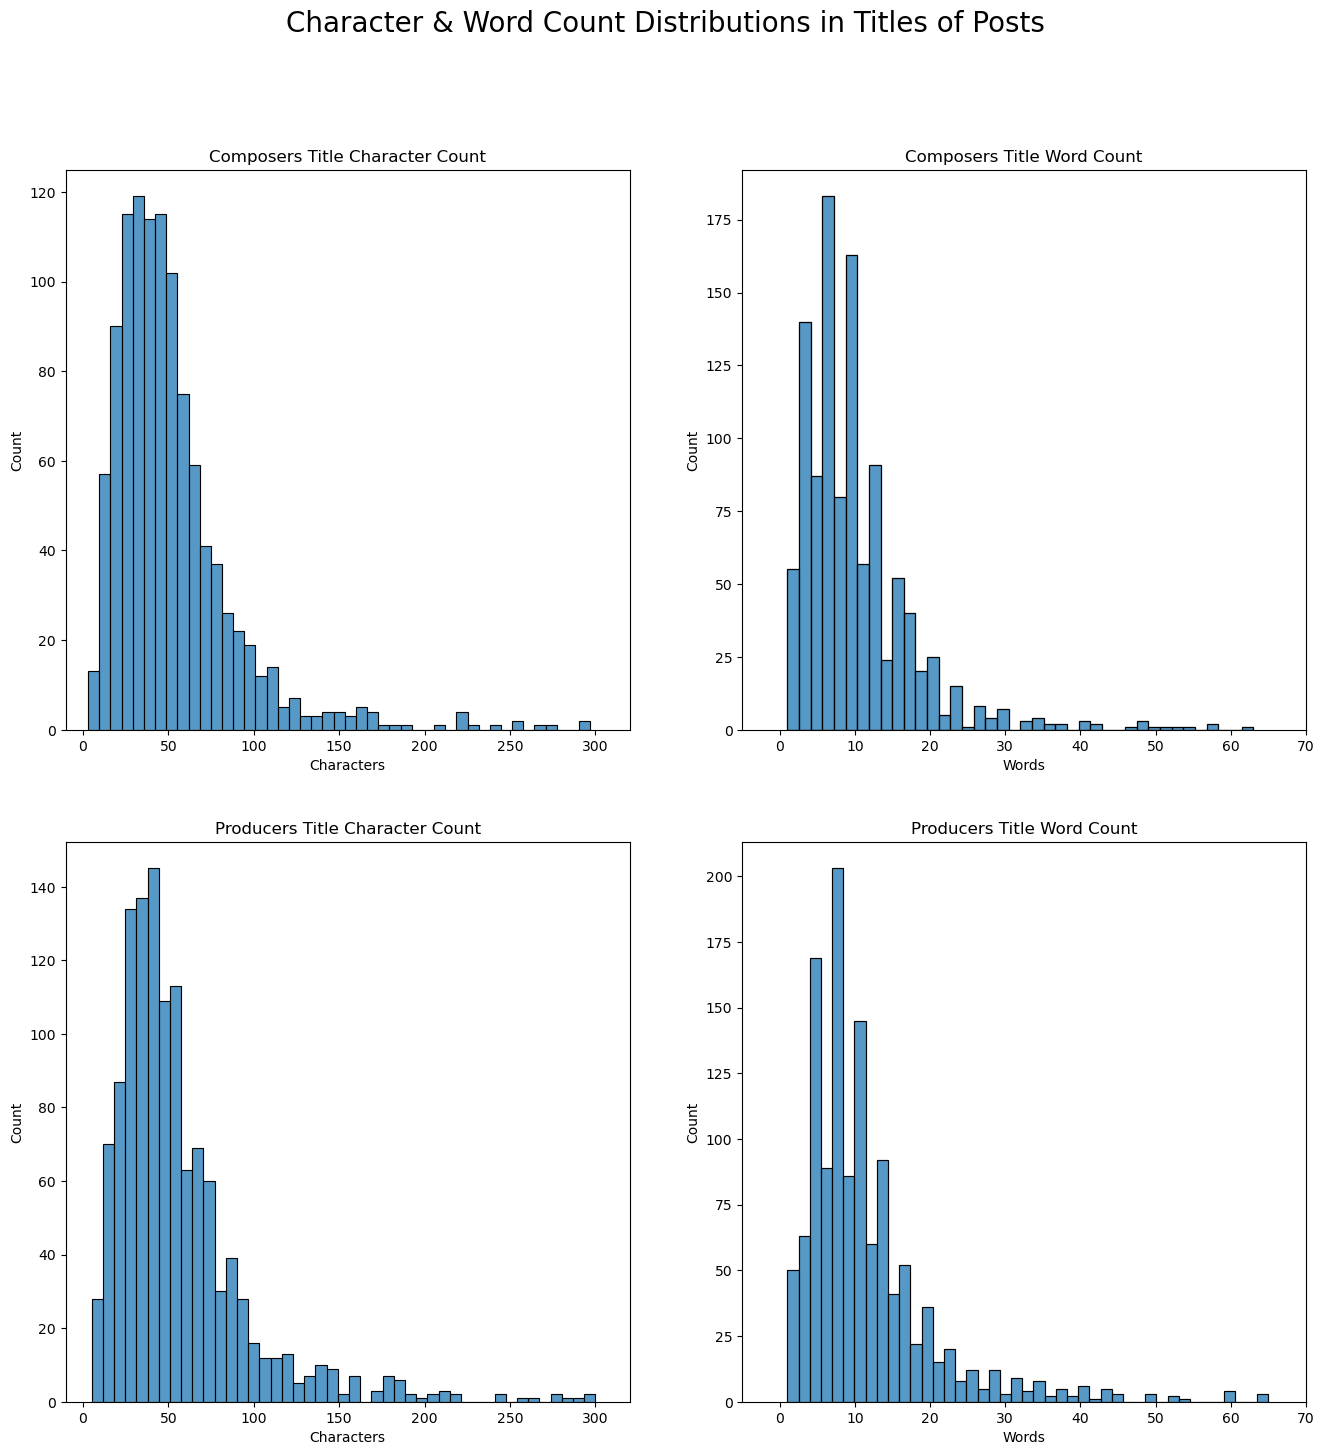

In [12]:
# Plot the word and character counts in titles, for each subreddit
comps=df[df.subreddit=='Composers']
prods=df[df.subreddit=='Producers']

fig, ax = plt.subplots(2,2, figsize=(16,16))
sns.histplot(comps['title_chars'], ax=ax[0,0])
sns.histplot(prods['title_chars'], ax=ax[1,0])
sns.histplot(comps['title_words'], ax=ax[0,1])
sns.histplot(prods['title_words'], ax=ax[1,1])

#Make the two plots in each row share the same horizontal axis
#(also set titles)
ax[0,0].set(xlabel='Characters', title='Composers Title Character Count', xlim=[-10,320])
ax[1,0].set(xlabel='Characters', title='Producers Title Character Count', xlim=[-10,320])
ax[0,1].set(xlabel='Words', title='Composers Title Word Count', xlim=[-5,70])
ax[1,1].set(xlabel='Words', title='Producers Title Word Count', xlim=[-5,70])

#Set title for whole figure
fig.suptitle('Character & Word Count Distributions in Titles of Posts', fontsize=20);

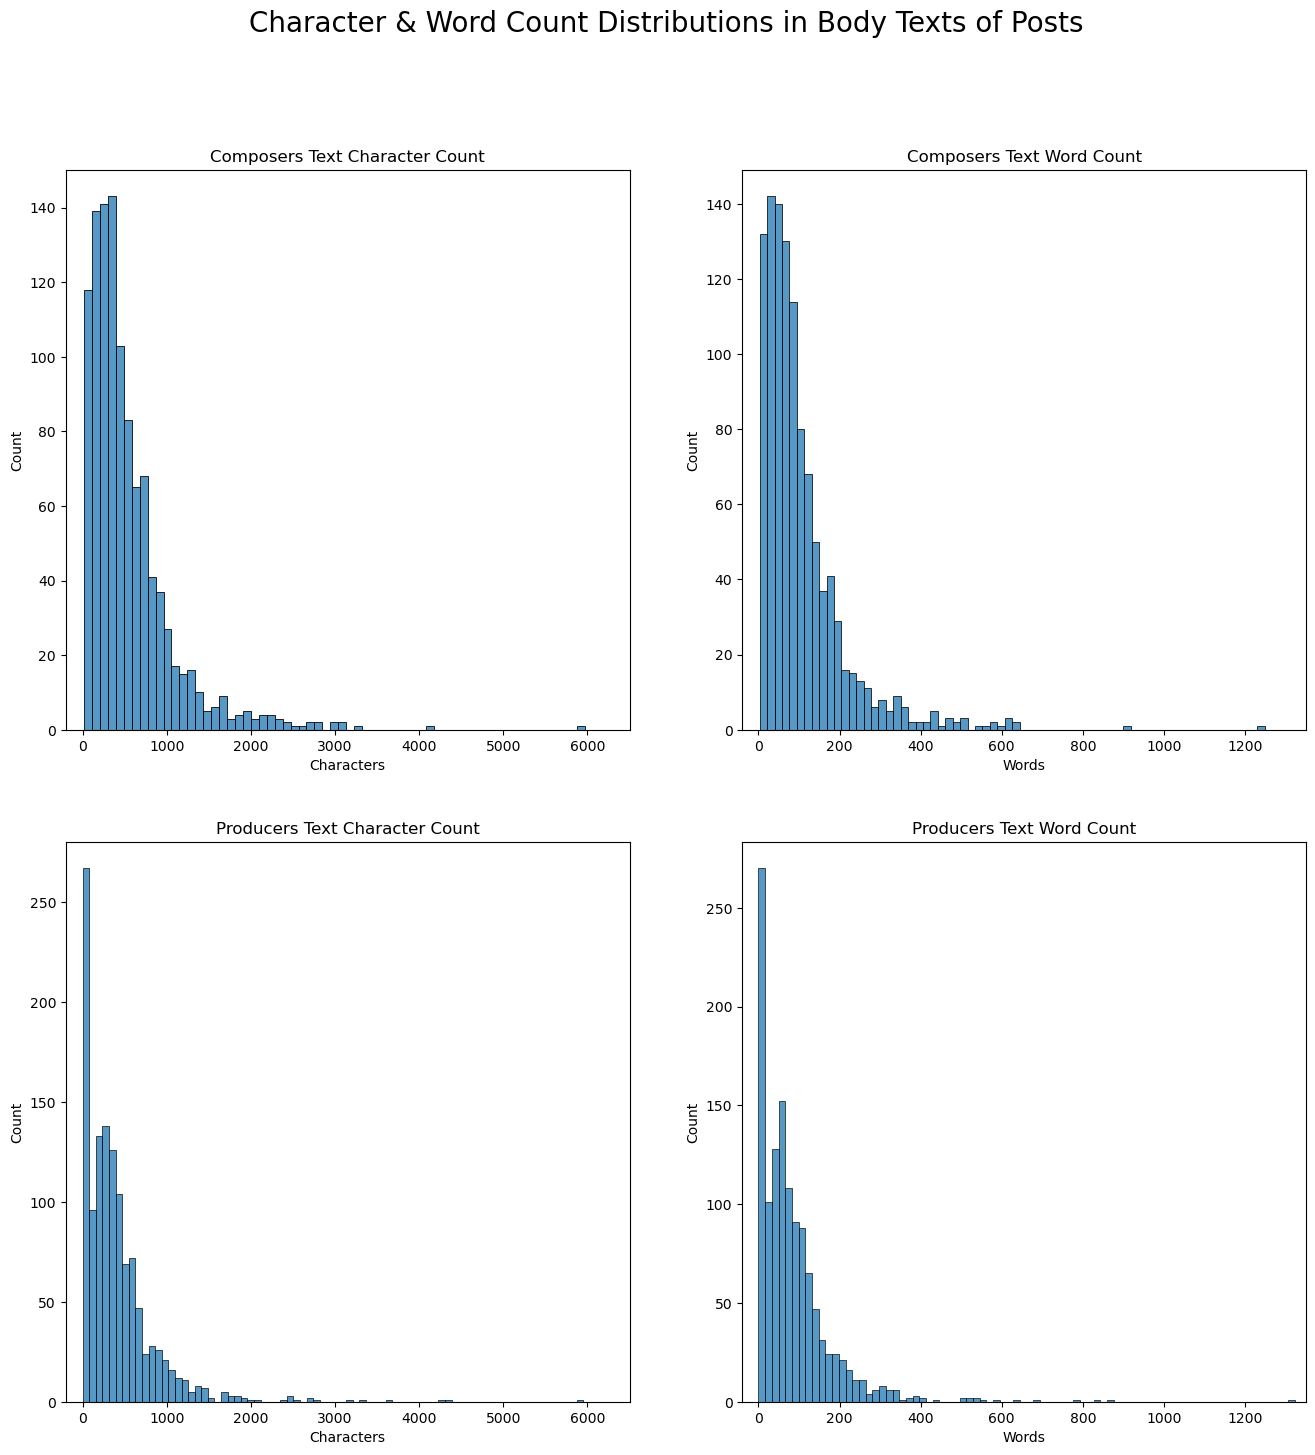

In [13]:
# Plot the word and character counts in body texts, for each subreddit
fig, ax = plt.subplots(2,2, figsize=(16,16))
sns.histplot(comps['text_chars'], ax=ax[0,0])
sns.histplot(prods['text_chars'], ax=ax[1,0])
sns.histplot(comps['text_words'], ax=ax[0,1])
sns.histplot(prods['text_words'], ax=ax[1,1])

ax[0,0].set(xlabel='Characters', title='Composers Text Character Count', xlim=[-200,6500])
ax[1,0].set(xlabel='Characters', title='Producers Text Character Count', xlim=[-200,6500])
ax[0,1].set(xlabel='Words', title='Composers Text Word Count', xlim=[-40,1350])
ax[1,1].set(xlabel='Words', title='Producers Text Word Count', xlim=[-40,1350])

#Set title for whole figure
fig.suptitle('Character & Word Count Distributions in Body Texts of Posts', fontsize=20);

It's clear that there's a large proportion of posts from the "Producers" subreddit that have zero length to the body text of their posts, while none of the "Composers" posts have zero length body texts.  Let's re-compare the body text distributions after ignoring those posts whose length is zero:

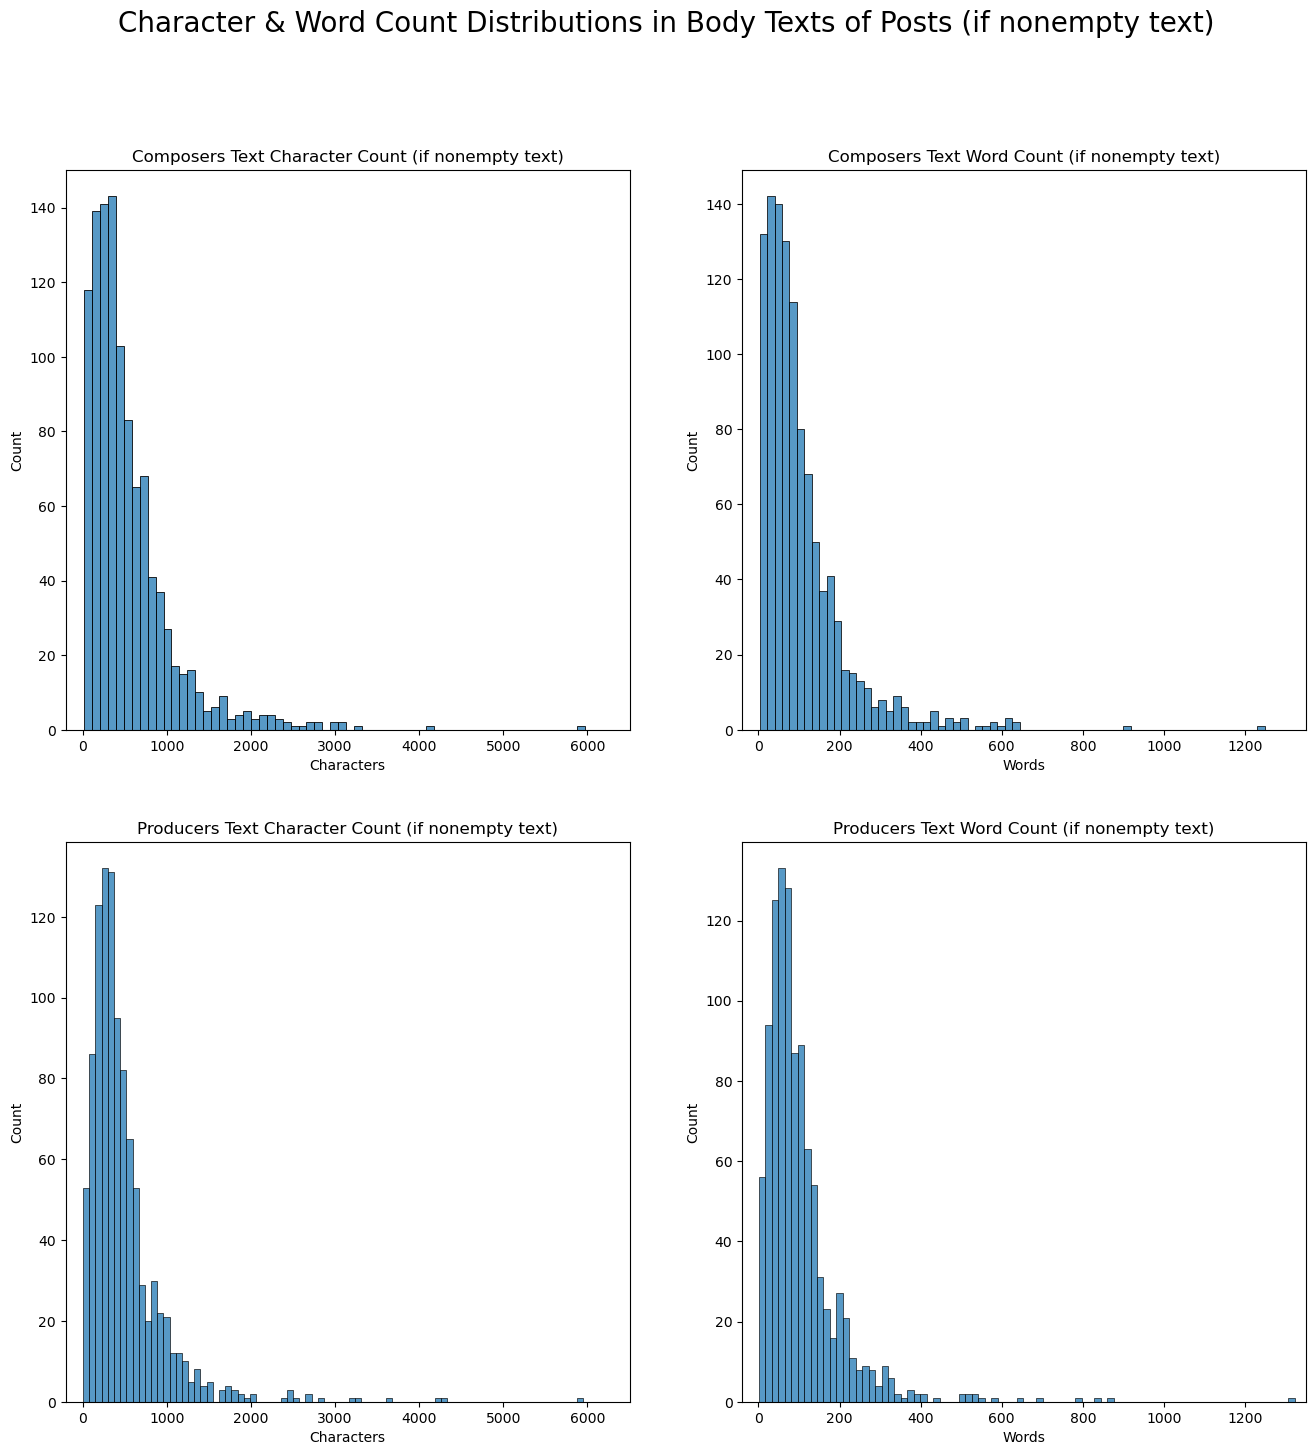

In [14]:
prods1 = prods[prods['text_chars']>0]
comps1 = comps[comps['text_chars']>0]

fig, ax = plt.subplots(2,2, figsize=(16,16))
sns.histplot(comps1['text_chars'], ax=ax[0,0])
sns.histplot(prods1['text_chars'], ax=ax[1,0])
sns.histplot(comps1['text_words'], ax=ax[0,1])
sns.histplot(prods1['text_words'], ax=ax[1,1])

ax[0,0].set(xlabel='Characters', title='Composers Text Character Count (if nonempty text)', xlim=[-200,6500])
ax[1,0].set(xlabel='Characters', title='Producers Text Character Count (if nonempty text)', xlim=[-200,6500])
ax[0,1].set(xlabel='Words', title='Composers Text Word Count (if nonempty text)', xlim=[-40,1350])
ax[1,1].set(xlabel='Words', title='Producers Text Word Count (if nonempty text)', xlim=[-40,1350])

#Set title for whole figure
fig.suptitle('Character & Word Count Distributions in Body Texts of Posts (if nonempty text)', fontsize=20);

#### Remarks on word and character count distributions

The "Composers" and "Producers" subreddits don't seem all that different in terms of the lengths and word counts of the *titles* of their posts.  Among the text, however, there is the obvious difference that the "Producers" data set contains many posts with empty body text while the "Composers" data set does not.  Even ignoring posts with zero body text, though, the distributions appear very slightly different; the "Composers" distributions have a slightly larger proportion of their mass just to the right of the peak in the distribution than the corresponding "Producers" distributions do.

This all means that including word or character counts for the titles of posts is unlikely to be all that useful in predictive modeling, but including word/character counts for *body texts* of posts may be useful.

## Examining word count outliers

As we can see, there are only a few posts from either Subreddit with more than ~650 words, and these posts' word counts are perhaps outliers.  Is there anything strange going on with these posts?

In [15]:
#Examine posts with long word counts
for message in df[df['text_words']>650]['text']:
    print('='*100)
    print(message)

Hi All,

I have now made music for about 2-3 years, I have written pieces I am proud of, I have also written some that I did not share with the world, but I always try to make a conscious effort to not let perfectionism get in the way of sharing my music with the world and tell myself "It's good enough, just release it!".

Now, I have unfortunately noticed that I find it very hard to sit down and actually start writing some new music regularly... I have managed to find the culprit of this and narrowed it down to a simple but important factor in the process; and that is to come up with an idea and them turn it into a full piece of music that is more than just 1 minute long.

I write orchestral and hybrid video game music, and I keep hearing my favourite composers spit out 4-5 minutes of music like it's nothing - A part of me wants to be able to do this, but I sometimes find it extremely hard to get past the 2 minute mark, due to not knowing where to take the music and its different sect

There doesn't seem to be anything particularly strange about these posts, so we'll leave them as they are.

# Most Frequent Words

To get a basic understanding of the posts in both subreddits, we'll now examine the most common words that appear in the titles and body texts of posts from each subreddit.

In [16]:
cv = CountVectorizer(stop_words = stopwords.words('english'))

comps_title_words = cv.fit_transform(comps['title'])
comps_title_words_df = pd.DataFrame(comps_title_words.todense(), columns=cv.get_feature_names_out())

prods_title_words = cv.fit_transform(prods['title'])
prods_title_words_df = pd.DataFrame(prods_title_words.todense(), columns=cv.get_feature_names_out())

comps_text_words = cv.fit_transform(comps['text'])
comps_text_words_df = pd.DataFrame(comps_text_words.todense(), columns=cv.get_feature_names_out())

prods_text_words = cv.fit_transform(prods['text'])
prods_text_words_df = pd.DataFrame(prods_text_words.todense(), columns=cv.get_feature_names_out())

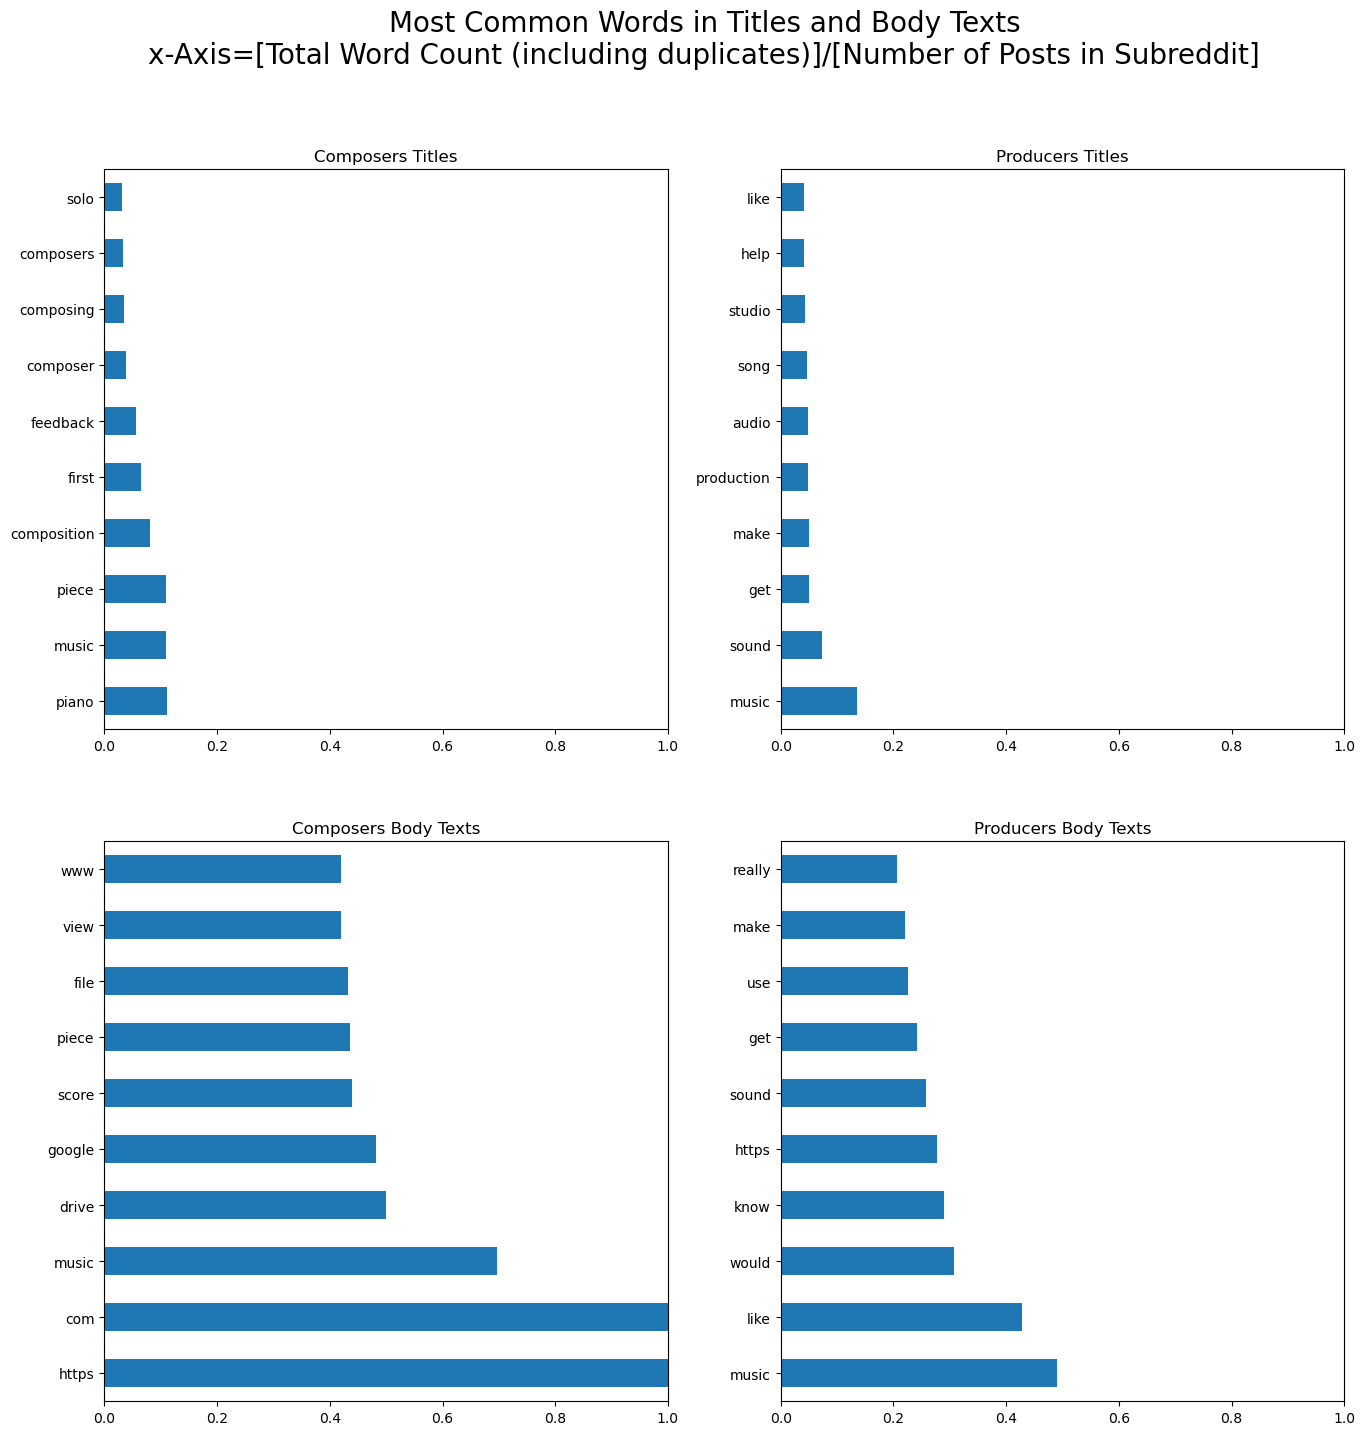

In [17]:
fig, ax = plt.subplots(2,2, figsize=(16,16))

comps_title_words_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[0,0],
                                                                     title='Composers Titles',
                                                                     xlim=[0,1])
comps_text_words_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[1,0],
                                                                     title='Composers Body Texts',
                                                                    xlim=[0,1])
prods_title_words_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[0,1],
                                                                     title='Producers Titles',
                                                                     xlim=[0,1])
prods_text_words_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[1,1],
                                                                     title='Producers Body Texts',
                                                                    xlim=[0,1])

#Set title for whole figure
fig.suptitle('Most Common Words in Titles and Body Texts\nx-Axis=[Total Word Count (including duplicates)]/[Number of Posts in Subreddit]', fontsize=20);

Note that the x-Axis in each of these charts represents the total number of times a given word appears divided by the total number of posts in that subreddit.  For example, in the "Composers Body Texts" chart, the word 'music' has a value of about two-thirds.  This means that the word 'music' appears in the body texts of "Composers" posts about two-thirds as many times as we have posts from that subreddit.  **This does *not* mean that two-thirds of "Composers" posts have the word 'music' in their body text**.  Indeed, perhaps only about one third of posts use the word 'music' at all, but these posts that contain the word 'music' on average use it twice.  Similarly, the expression 'https' probably is assigned a number *greater than 1*, indicating that the total number of times it appears in "Composers" posts' body texts is greater than the total number of posts.

Two issues are apparent from the charts above.  First, the words "composers", "composing", "composer" and "composition" all have the same root, so some lemmatization might help combine these into a single word.  We'll do this later.

Second, it looks like may of these "most common words" are just parts of URLs.  So let's write a preprocessing function that replaces each URL with a single word corresponding to the name of the website to which it is linking:

In [18]:
def website_name(url):
    '''
    Input: A webiste URL
    Output: the name of that website, followed by "link." For example,
        'http://www.hello.com/hi' returns 'hellolink'.
    If the website doesn't have one of the standard URL endings listed in
    ending_bases in the definition of this function, then this simply returns
    'unknownlink'.
    '''
    
    endings_bases = ['com', 'net', 'org', 'gov', 'io', 'co']
    endings = [f".{x}"+r'(\W|$)' for x in endings_bases]
    #The e.g. ".com" must be followed by either the end of the string OR a
    #non-alphanumeric character.  This is to make sure that we
    #capture the .com from something.com or something.com/else, but not the
    #"comcast" in help.comcast.net
    
    ending_pos = -1
    #Initialize in case we can't find any of these endings in the URL
    
    for ending in endings:
        #Look for these endings in the url
        if bool(re.search(ending, url)):
            ending_pos = re.search(ending, url).start()
            break
            #If you found it, remember its position and break out
        else:
            continue
            #If you didn't find this one, try the next kind of ending
    
    #If we can't find an ending, just return 'unknownlink'
    if ending_pos == -1:
        return 'unknownlink'
    
    #Otherwise, take everything after the last '.' before this ending
    before_ending = url[:ending_pos]
    parts_of_url = before_ending.split('.')
    return parts_of_url[-1]+'link'


In [19]:
#An example
website_name('https://www.youtube.com/watch?v=hKkR4YFtyJk')

'youtubelink'

In [20]:
#Another example
website_name('https://en.wikipedia.org/wiki/Solomonoff%27s_theory_of_inductive_inference')

'wikipedialink'

In [21]:
#An example with an unrecognized website ending
website_name('https://generalassemb.ly/education/data-science-immersive/new-york-city')

'unknownlink'

In [22]:
def replace_urls(text):
    url_pattern = '(?:https?:\/\/|www\.)\S+'
    #Regex pattern for something beginning with http://, https://, or www.
    #We need to put a '?:' after the first '(' in the () group so that re
    #captures the WHOLE pattern and not just the group in the ().

    text = re.sub(url_pattern, lambda x : website_name(x.group()),text)
    # .group just gets this instance of the text that was found by the pattern
    
    return text

## Custom preprocessors

In [23]:
def url_preprocessor(text):
    '''
    Converts text to lowercase then replaces URLs with the names of the sites followed by "link".
    '''
    text = text.lower()
    text = replace_urls(text)
    
    return text

In [24]:
sentence = "I like https://www.youtube.com/watch?v=hKkR4YFtyJk, but overall I like https://en.wikipedia.org/wiki/Claude_Debussy more."
print(f"Original string: {sentence}")
print(f"After function: {url_preprocessor(sentence)}")

Original string: I like https://www.youtube.com/watch?v=hKkR4YFtyJk, but overall I like https://en.wikipedia.org/wiki/Claude_Debussy more.
After function: i like youtubelink but overall i like wikipedialink more.


In [25]:
def stem_processor(text):
    words = re.split('\s+', text)
    ps = PorterStemmer()
    words_stemmed = [ps.stem(x) for x in words]
    text = " ".join(words_stemmed)
    return text

In [26]:
stem_processor("Hey, don't you think composers should be the same as composing - in a word count?")

"hey, don't you think compos should be the same as compos - in a word count?"

Now that we have built these custom preprocessors, we can re-examine the most common words.  First, we will only replace URLs with the `url_processor` function.  Then we will both replace URLs and use the `stem_processor` to stem the words.

For use in future notebooks, we have also copied these custom functions and processors into the `processing_functions.py` [file](./processing_functions.py).

## Most frequent words - after replacing URLs but NO stemming

In [27]:
cv = CountVectorizer(stop_words = stopwords.words('english'),
                     preprocessor=url_preprocessor)

comps_title_words = cv.fit_transform(comps['title'])
comps_title_words_df = pd.DataFrame(comps_title_words.todense(), columns=cv.get_feature_names_out())

prods_title_words = cv.fit_transform(prods['title'])
prods_title_words_df = pd.DataFrame(prods_title_words.todense(), columns=cv.get_feature_names_out())

comps_text_words = cv.fit_transform(comps['text'])
comps_text_words_df = pd.DataFrame(comps_text_words.todense(), columns=cv.get_feature_names_out())

prods_text_words = cv.fit_transform(prods['text'])
prods_text_words_df = pd.DataFrame(prods_text_words.todense(), columns=cv.get_feature_names_out())

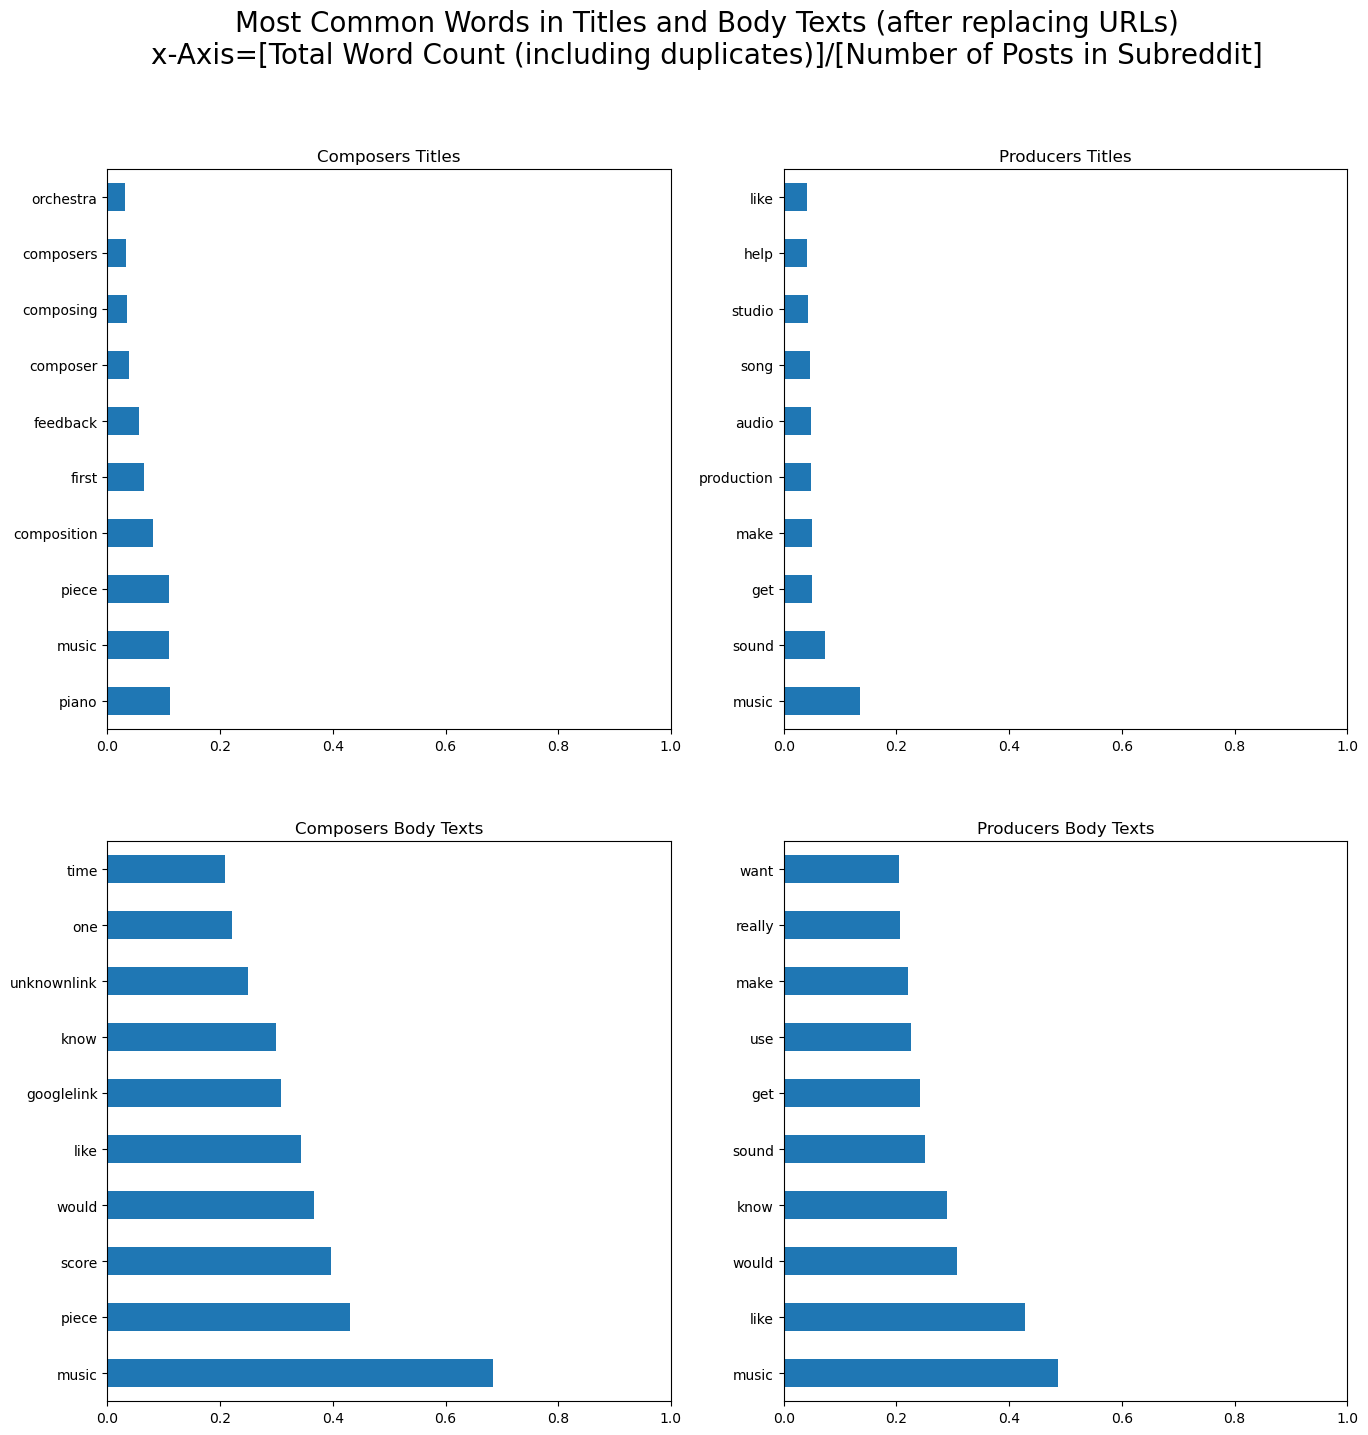

In [28]:
fig, ax = plt.subplots(2,2, figsize=(16,16))

comps_title_words_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[0,0],
                                                                     title='Composers Titles',
                                                                     xlim=[0,1])
comps_text_words_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[1,0],
                                                                     title='Composers Body Texts',
                                                                     xlim=[0,1])
prods_title_words_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[0,1],
                                                                     title='Producers Titles',
                                                                     xlim=[0,1])
prods_text_words_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[1,1],
                                                                     title='Producers Body Texts',
                                                                     xlim=[0,1])

#Set title for whole figure
fig.suptitle('Most Common Words in Titles and Body Texts (after replacing URLs)\nx-Axis=[Total Word Count (including duplicates)]/[Number of Posts in Subreddit]', fontsize=20);

## Most frequent words - after replacing URLs and stemming

In [29]:
cv = CountVectorizer(stop_words = stopwords.words('english'),
                     preprocessor= lambda x : stem_processor(url_preprocessor(x)))

comps_title_words = cv.fit_transform(comps['title'])
comps_title_words_df = pd.DataFrame(comps_title_words.todense(), columns=cv.get_feature_names_out())

prods_title_words = cv.fit_transform(prods['title'])
prods_title_words_df = pd.DataFrame(prods_title_words.todense(), columns=cv.get_feature_names_out())

comps_text_words = cv.fit_transform(comps['text'])
comps_text_words_df = pd.DataFrame(comps_text_words.todense(), columns=cv.get_feature_names_out())

prods_text_words = cv.fit_transform(prods['text'])
prods_text_words_df = pd.DataFrame(prods_text_words.todense(), columns=cv.get_feature_names_out())

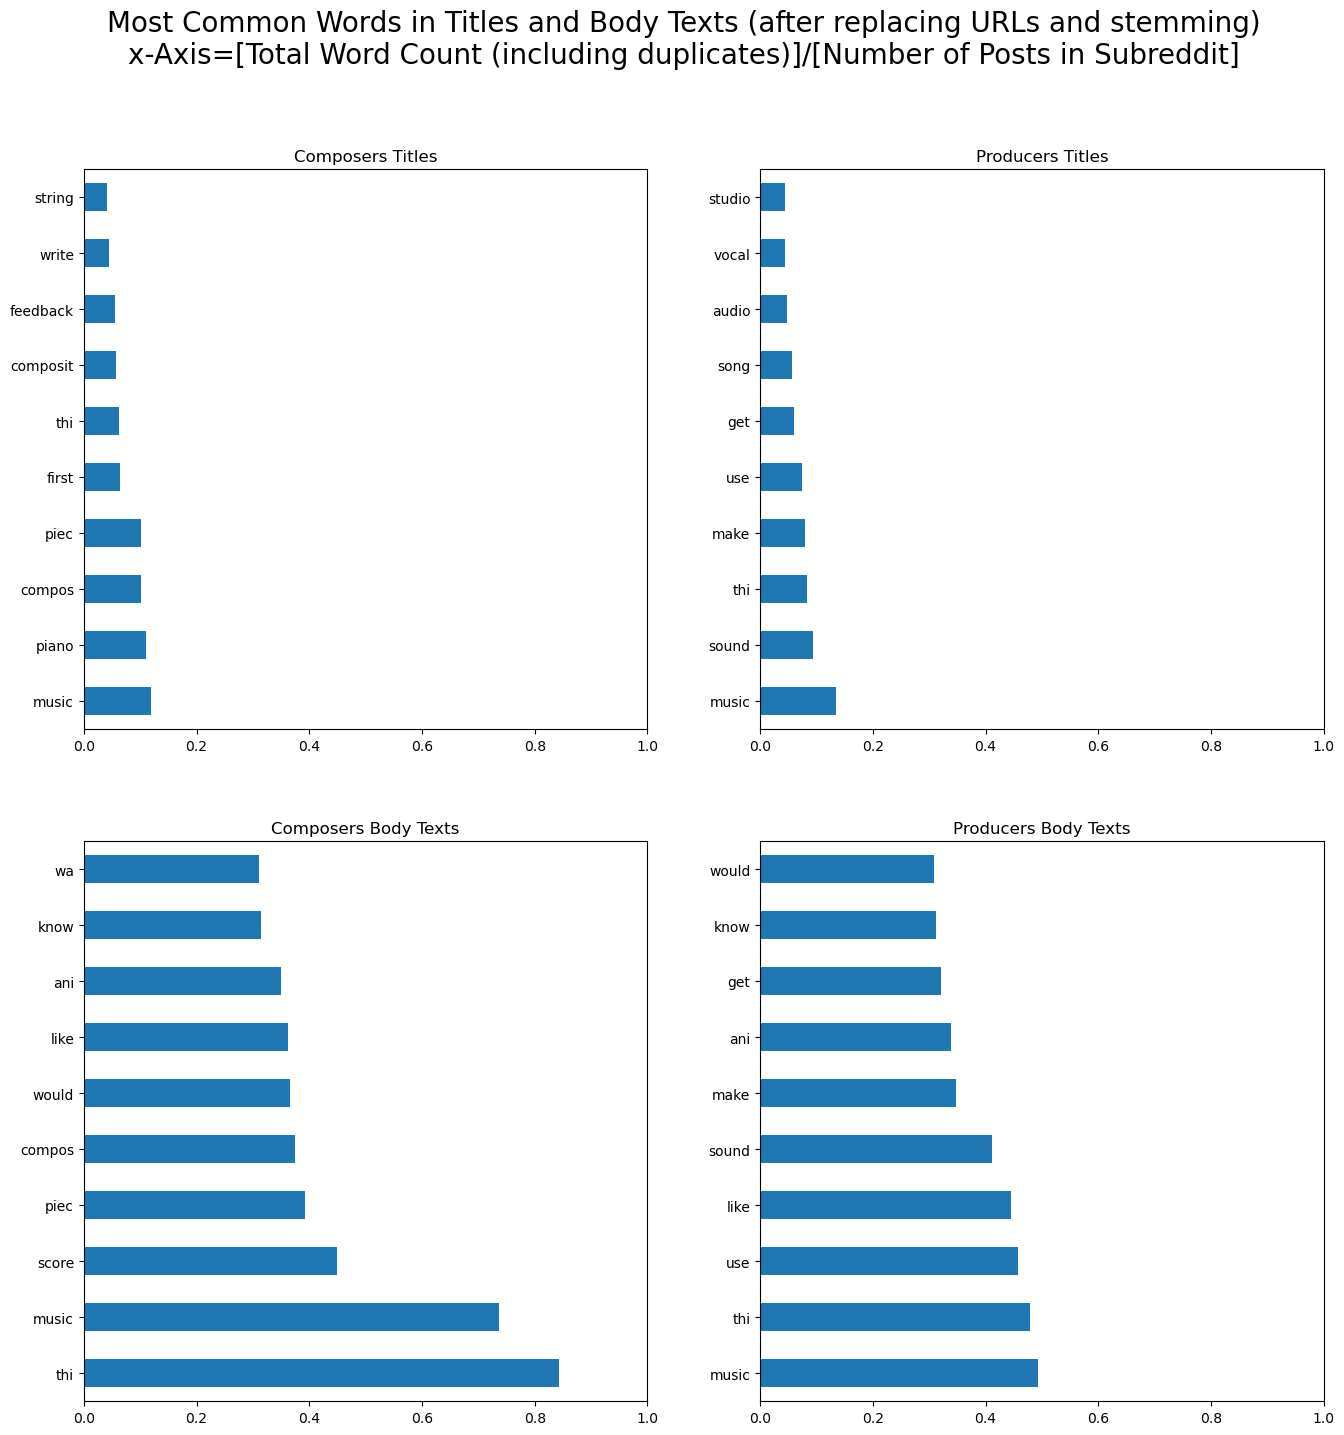

In [30]:
fig, ax = plt.subplots(2,2, figsize=(16,16))

comps_title_words_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[0,0],
                                                                     title='Composers Titles',
                                                                     xlim=[0,1])
comps_text_words_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[1,0],
                                                                     title='Composers Body Texts',
                                                                    xlim=[0,1])
prods_title_words_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[0,1],
                                                                     title='Producers Titles',
                                                                     xlim=[0,1])
prods_text_words_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[1,1],
                                                                     title='Producers Body Texts',
                                                                    xlim=[0,1])

#Set title for whole figure
fig.suptitle('Most Common Words in Titles and Body Texts (after replacing URLs and stemming)\nx-Axis=[Total Word Count (including duplicates)]/[Number of Posts in Subreddit]', fontsize=20);

This is a more reasonable approximation of the "real" most common word types.  However, these lists still contain some very common words (or rather, stems of very common words).  To deal with this, we can try a Term Frequency - Inverse Document Frequency (TF-IDF) transformation of the word counts:

## Top words after TF-IDF transformation (and replacing URLs and stemming)

In [31]:
tfv = TfidfVectorizer(stop_words = stopwords.words('english'),
                     preprocessor=lambda x : stem_processor(url_preprocessor(x)))

tfidf_comps_title_words = tfv.fit_transform(comps['title'])
tfidf_comps_title_words_df = pd.DataFrame(tfidf_comps_title_words.todense(), columns=tfv.get_feature_names_out())

tfidf_prods_title_words = tfv.fit_transform(prods['title'])
tfidf_prods_title_words_df = pd.DataFrame(tfidf_prods_title_words.todense(), columns=tfv.get_feature_names_out())

tfidf_comps_text_words = tfv.fit_transform(comps['text'])
tfidf_comps_text_words_df = pd.DataFrame(tfidf_comps_text_words.todense(), columns=tfv.get_feature_names_out())

tfidf_prods_text_words = tfv.fit_transform(prods['text'])
tfidf_prods_text_words_df = pd.DataFrame(tfidf_prods_text_words.todense(), columns=tfv.get_feature_names_out())

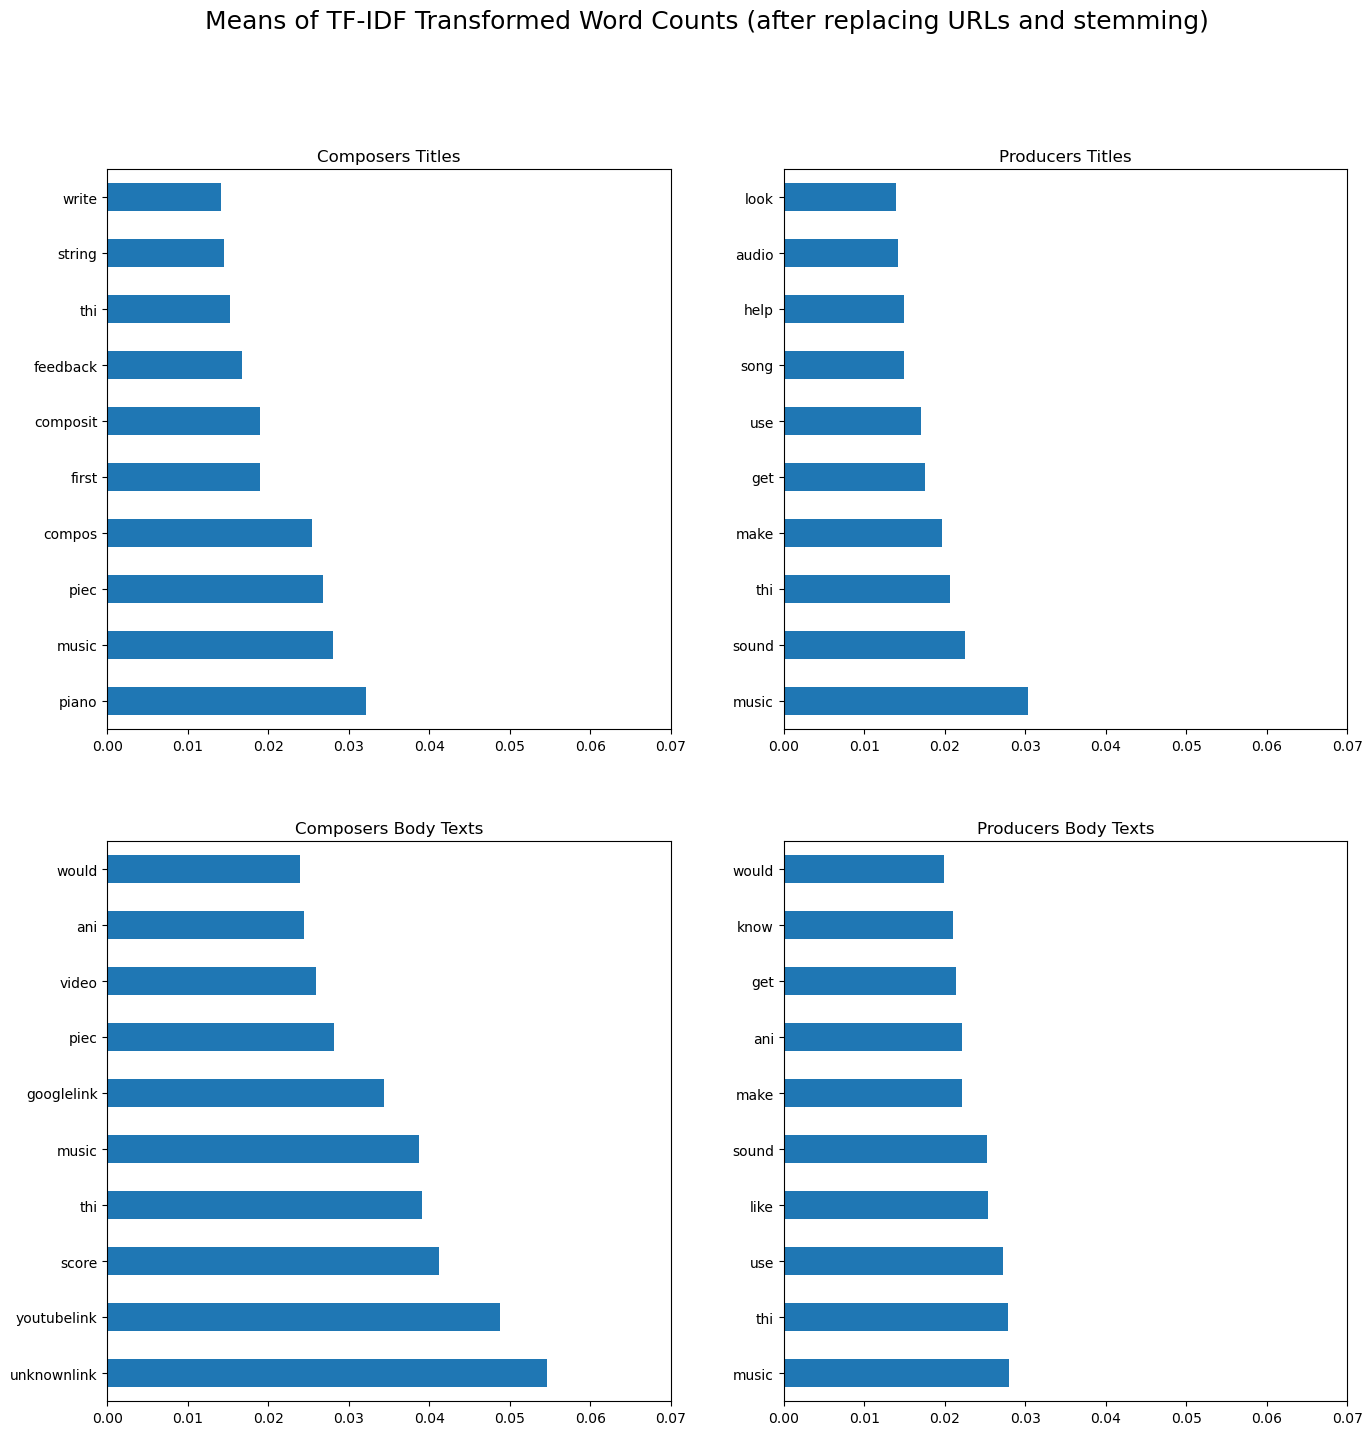

In [32]:
fig, ax = plt.subplots(2,2, figsize=(16,16))

tfidf_comps_title_words_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[0,0],
                                                                     title='Composers Titles',
                                                                     xlim=[0,.07])
tfidf_comps_text_words_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[1,0],
                                                                     title='Composers Body Texts',
                                                                    xlim=[0,.07])
tfidf_prods_title_words_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[0,1],
                                                                     title='Producers Titles',
                                                                     xlim=[0,.07])
tfidf_prods_text_words_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[1,1],
                                                                     title='Producers Body Texts',
                                                                    xlim=[0,.07])

#Set title for whole figure
fig.suptitle('Means of TF-IDF Transformed Word Counts (after replacing URLs and stemming)', fontsize=18);

This transformation didn't seem to help.  For the titles of "Composers" posts, it mostly just permuted the order of the top 10 posts.  For the "Producers" titles, it seems to have replaced some actually-distinctive words (like "studio" and "vocal") with common words (like "look" and "help").  We will probably not want to use TF-IDF during the modeling process.

Another set of features that may be useful for modeling are the bigrams present in the posts.  Let's examine the most common ones, both with and without stemming:

## Most frequent bigrams (after replacing URLs but NO stemming)

In [33]:
cv = CountVectorizer(stop_words = stopwords.words('english'),
                     preprocessor=url_preprocessor,
                     ngram_range=(2,2))

comps_title_bigrams = cv.fit_transform(comps['title'])
comps_title_bigrams_df = pd.DataFrame(comps_title_bigrams.todense(), columns=cv.get_feature_names_out())

prods_title_bigrams = cv.fit_transform(prods['title'])
prods_title_bigrams_df = pd.DataFrame(prods_title_bigrams.todense(), columns=cv.get_feature_names_out())

comps_text_bigrams = cv.fit_transform(comps['text'])
comps_text_bigrams_df = pd.DataFrame(comps_text_bigrams.todense(), columns=cv.get_feature_names_out())

prods_text_bigrams = cv.fit_transform(prods['text'])
prods_text_bigrams_df = pd.DataFrame(prods_text_bigrams.todense(), columns=cv.get_feature_names_out())

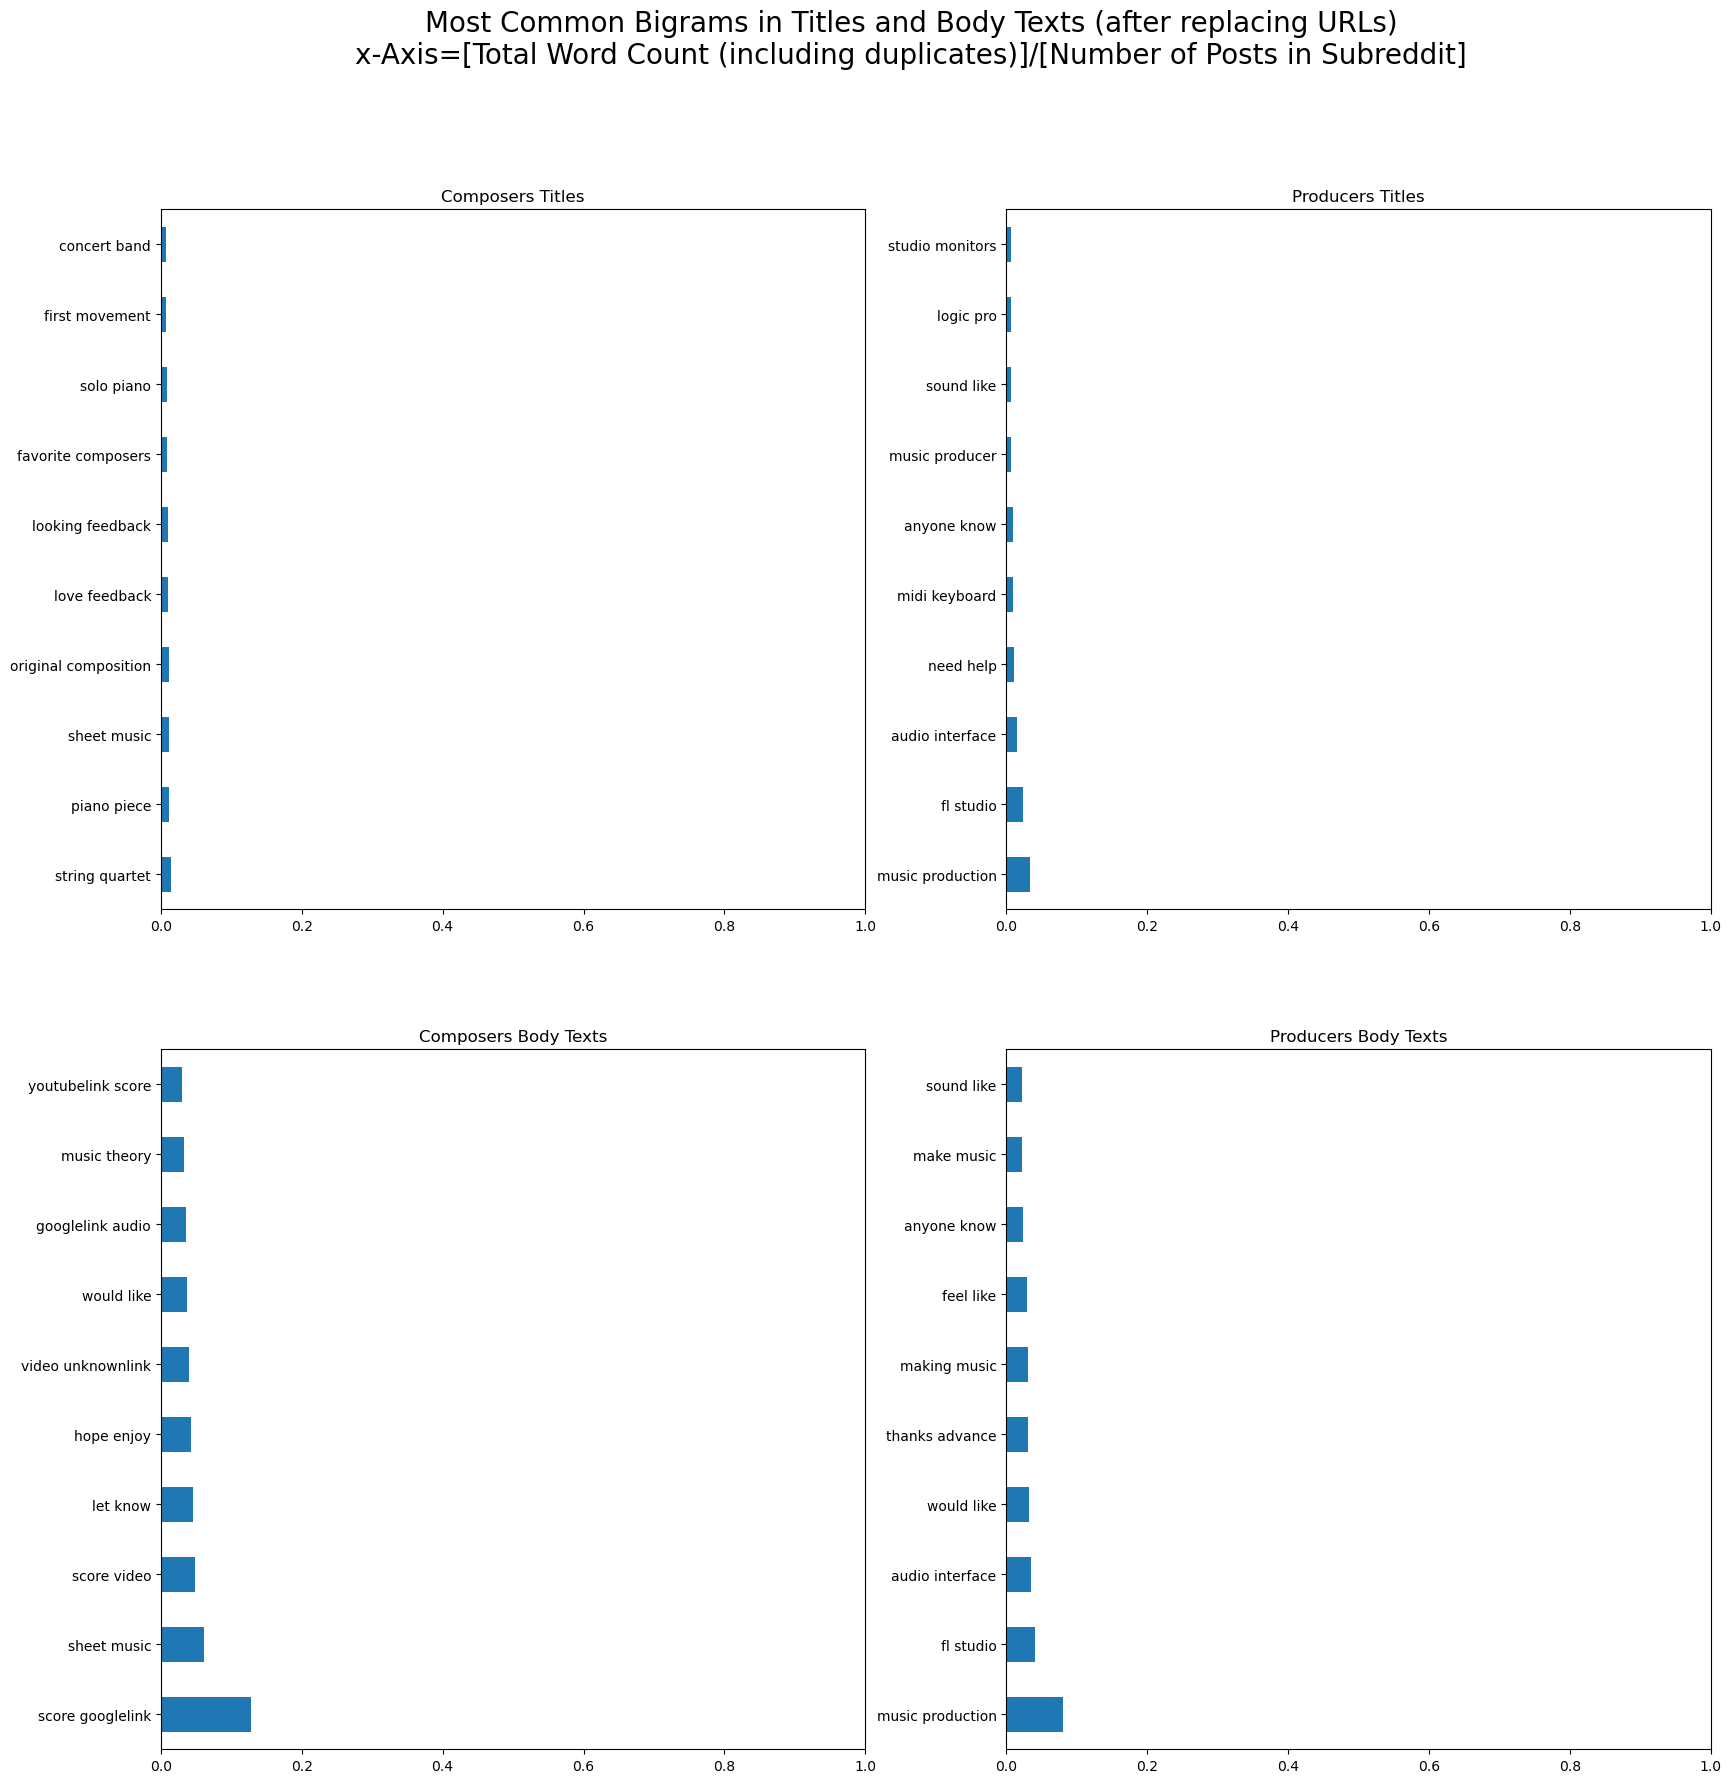

In [34]:
fig, ax = plt.subplots(2,2, figsize=(20,20))

comps_title_bigrams_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[0,0],
                                                                     title='Composers Titles',
                                                                        xlim=[0,1])
comps_text_bigrams_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[1,0],
                                                                     title='Composers Body Texts',
                                                                       xlim=[0,1])
prods_title_bigrams_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[0,1],
                                                                     title='Producers Titles',
                                                                        xlim=[0,1])
prods_text_bigrams_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[1,1],
                                                                     title='Producers Body Texts',
                                                                       xlim=[0,1])

#Set title for whole figure
fig.suptitle('Most Common Bigrams in Titles and Body Texts (after replacing URLs)\nx-Axis=[Total Word Count (including duplicates)]/[Number of Posts in Subreddit]', fontsize=20);

## Most frequent bigrams (after replacing URLs and stemming)

In [35]:
cv = CountVectorizer(stop_words = stopwords.words('english'),
                     preprocessor=lambda x : stem_processor(url_preprocessor(x)),
                     ngram_range=(2,2))

comps_title_bigrams = cv.fit_transform(comps['title'])
comps_title_bigrams_df = pd.DataFrame(comps_title_bigrams.todense(), columns=cv.get_feature_names_out())

prods_title_bigrams = cv.fit_transform(prods['title'])
prods_title_bigrams_df = pd.DataFrame(prods_title_bigrams.todense(), columns=cv.get_feature_names_out())

comps_text_bigrams = cv.fit_transform(comps['text'])
comps_text_bigrams_df = pd.DataFrame(comps_text_bigrams.todense(), columns=cv.get_feature_names_out())

prods_text_bigrams = cv.fit_transform(prods['text'])
prods_text_bigrams_df = pd.DataFrame(prods_text_bigrams.todense(), columns=cv.get_feature_names_out())

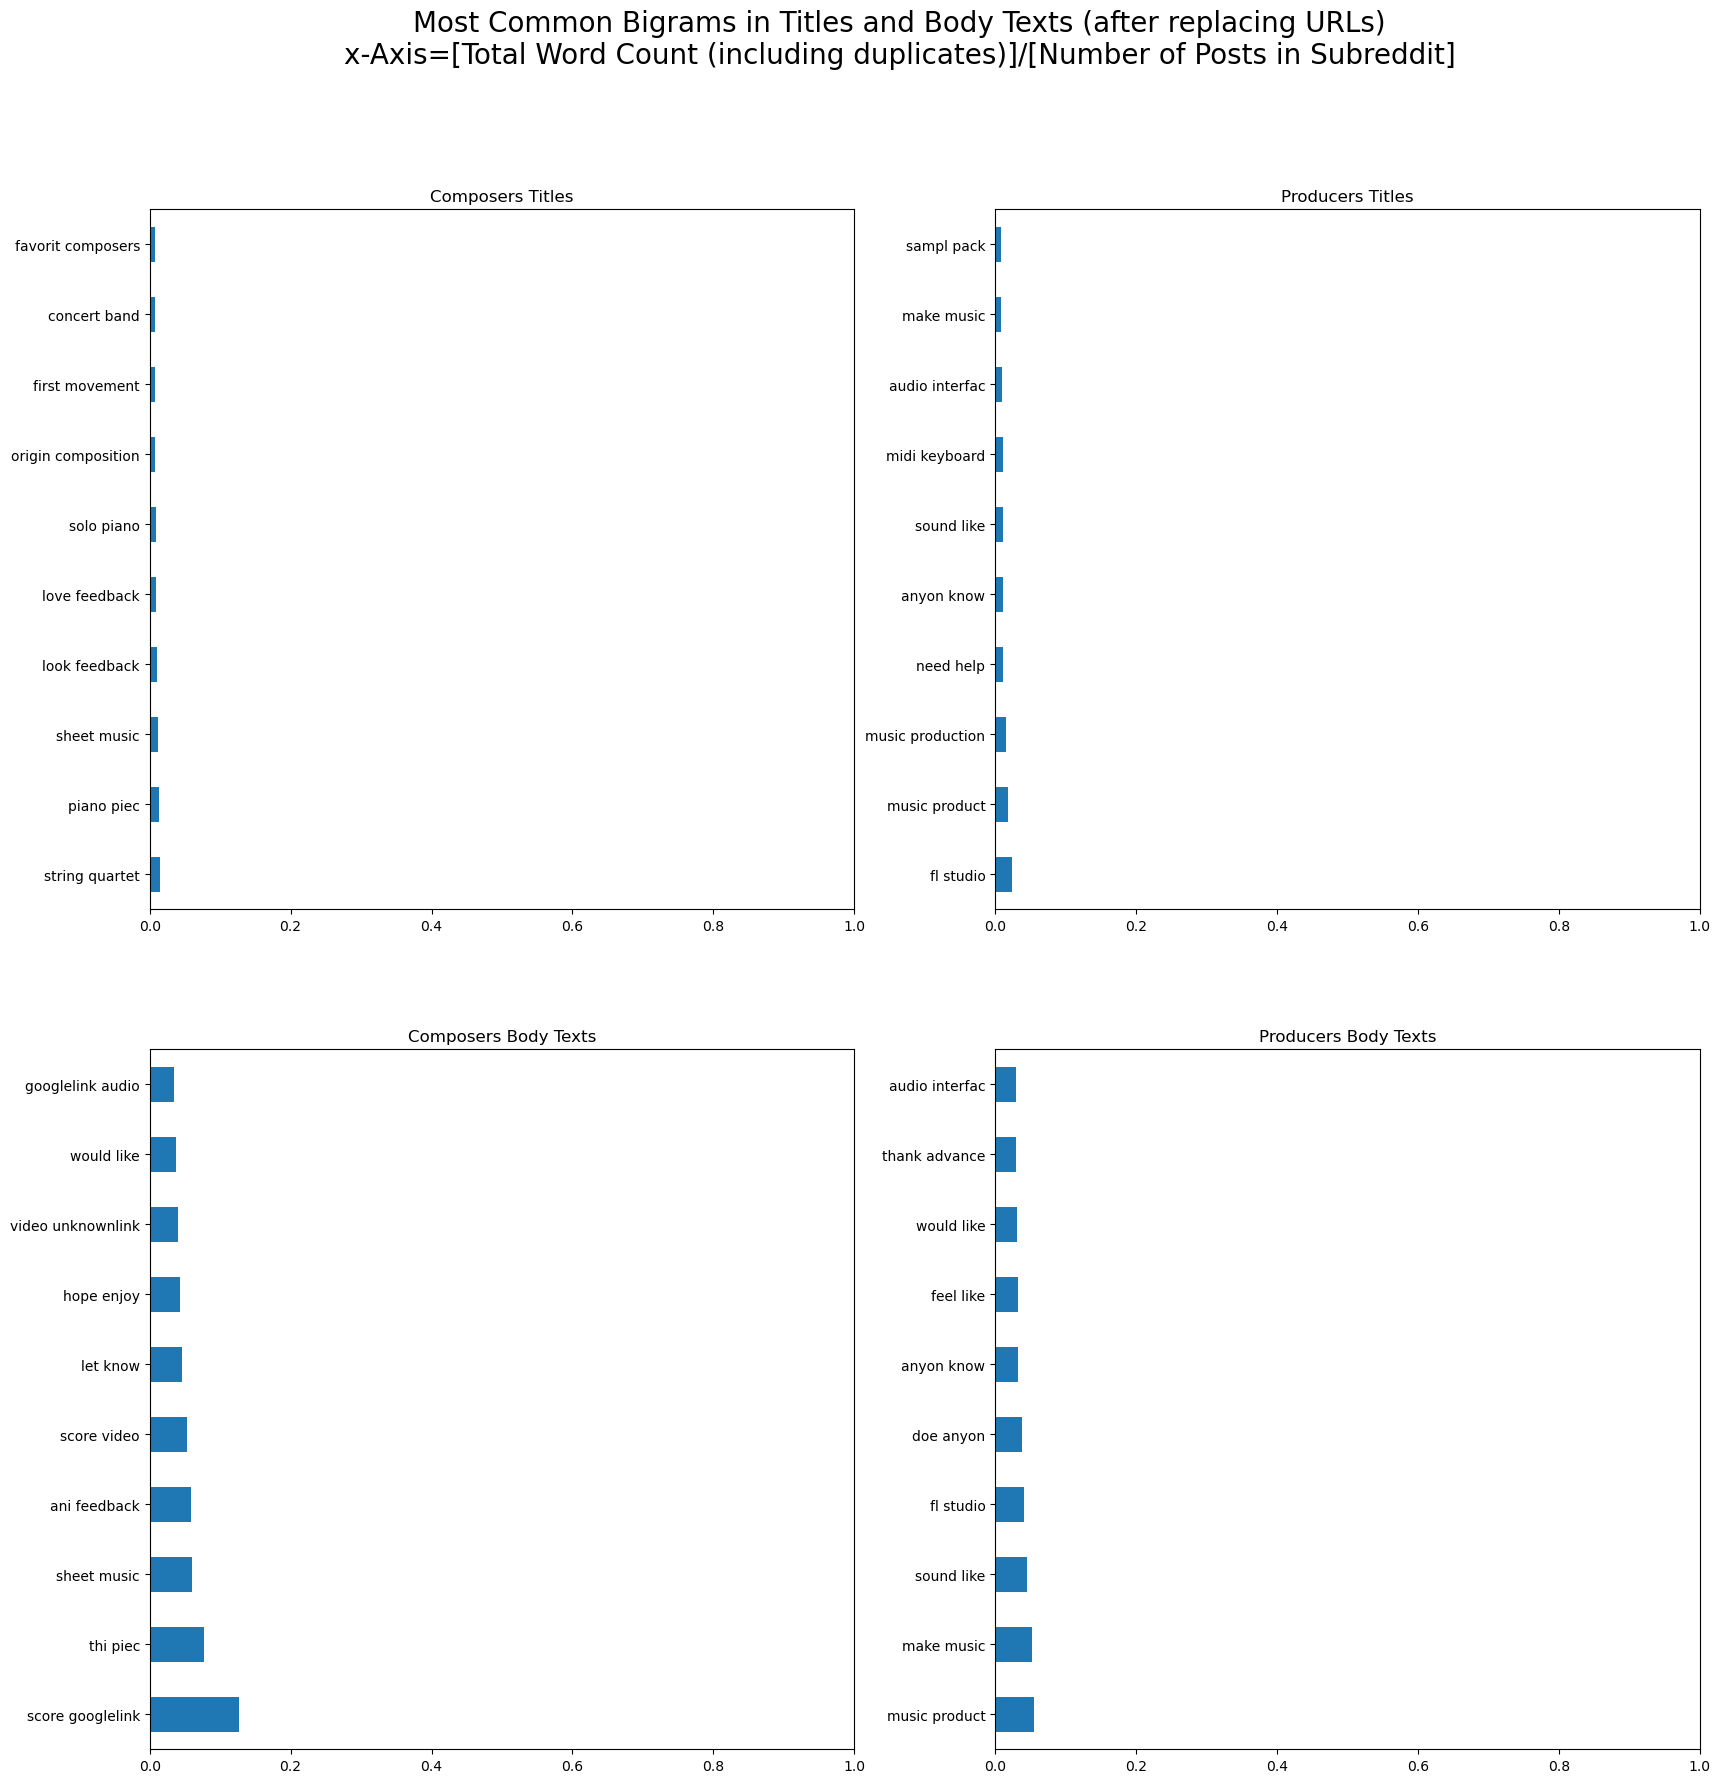

In [36]:
fig, ax = plt.subplots(2,2, figsize=(20,20))

comps_title_bigrams_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[0,0],
                                                                     title='Composers Titles',
                                                                        xlim=[0,1])
comps_text_bigrams_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[1,0],
                                                                     title='Composers Body Texts',
                                                                       xlim=[0,1])
prods_title_bigrams_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[0,1],
                                                                     title='Producers Titles',
                                                                        xlim=[0,1])
prods_text_bigrams_df.mean().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[1,1],
                                                                     title='Producers Body Texts',
                                                                       xlim=[0,1])

#Set title for whole figure
fig.suptitle('Most Common Bigrams in Titles and Body Texts (after replacing URLs)\nx-Axis=[Total Word Count (including duplicates)]/[Number of Posts in Subreddit]', fontsize=20);

As we can see, there are some slight differences between the "most common bigrams" charts that were made with / without stemming.  Thus, we might want to try both stemming and not stemming when we include bigrams in our models.

# Words that most strongly signal one subreddit over the other

Another thing we might do to understand our data is to see which words are most frequent among one subreddit compared to the other.  For each word, we take the ratio

**(Frequency of word in Composers subreddit) / (Frequency of word in Producers subreddit)**.

High values of this ratio indicate that the word is *relatively* much more common among the Composers subreddit; low values indicate that it is relatively much more common among the Producers subreddit.

One problem we might run into is that certain words appear in *only one* of the two subreddits.  In this case, these words might be *very strong* indicators of which subreddit the post came from, but they might also be *very poor* indicators of this.  For example, if the word 'gargantuan' happens to appear only once in *either* of the subreddits, and this one instance just happens to be in the Producers subreddit, this does not necessarily mean that the word 'gargantuan' is particularly indicative of the Producers subreddit.  Indeed, 'gargantuan' might just be a very uncommon word overall, and we *happened* to find our one instance of the word in the Producers data set.

One way that we might fix this problem is to require a word to appear in a certain minimum percentage of posts from a given subreddit before we consider it a "legitimate" word in that subreddit.  We can achieve this using the `min_df` hyperparameter of `CountVectorizer`.  Since it's not obvious in advance what the best value of the `min_df` hyperparameter should be, we'll explore this issue in the [final notebook](./05_advanced_modeling.ipynb).

## What's next?

In the [next notebook](04_modeling.ipynb), we create models to predict the subreddit to which a post belongs.